# DivNoising - Training
This notebook contains an example on how to train a DivNoising VAE.  This requires having a noise model (model of the imaging noise) which can be either measured from calibration data or estimated from raw noisy images themselves. If you haven't done so, please first run either ```0a-CreateNoiseModel.ipynb``` (if you have calibration data to create a noise model from) or the ntebook ```0b-CreateNoiseModel.ipynb``` if you do not have calibration data and you wish to use noisy images themselves to bootstrap a noise model. These notebooks will download the data and create a noise model.

In [6]:
import warnings
warnings.filterwarnings('ignore')

# We import all our dependencies.
import os
import numpy as np
import torch
import sys
sys.path.append('../../DivNoising/')
from src.config import train
from tifffile import imread
from divnoising import utils, training
from divnoising.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel

device = torch.cuda.current_device()
#if not torch.cuda.is_available():
#    raise ValueError("GPU not found, code will run on CPU and can be extremely slow!")

### Specify ```path``` to load data
Your data should be stored in the directory indicated by ```path```. This notebook expects 2D datasets in ```.tif``` format. If your data is a stack of 2D images, you can load it as shown in the next cell. If you dataset has multiple individual 2D tif files, comment out the second line in the cell below and uncomment the third line.

In [7]:
config_name = 'exp_divnoising_dot_noise'
dataset_type = 'synthetic'

# Training Data Preparation

For training we need to follow some preprocessing steps first which will prepare the data for training purposes. <br>
We first divide the data randomly into training and validation sets with 85% images allocated to training set  and rest to validation set. <br>
Then we augment the training data 8-fold by 90 degree rotations and flips, set `augment` flag to `False` to disable data augmentation. <br>
After that patches of size `patch_size` are extracted from training and validation images. <br>
Finally, we compute the mean and standard deviation of our combined train and validation sets and do some additional preprocessing.

In [9]:
x_train_tensor, x_val_tensor, mean, std = train.pre_processing(
    config_name=config_name,
    dataset_type=dataset_type
)

torch.Size([10, 1, 1536, 1024])
torch.Size([1, 1, 1536, 1024])
tensor(225.6740)
tensor(67.2028)


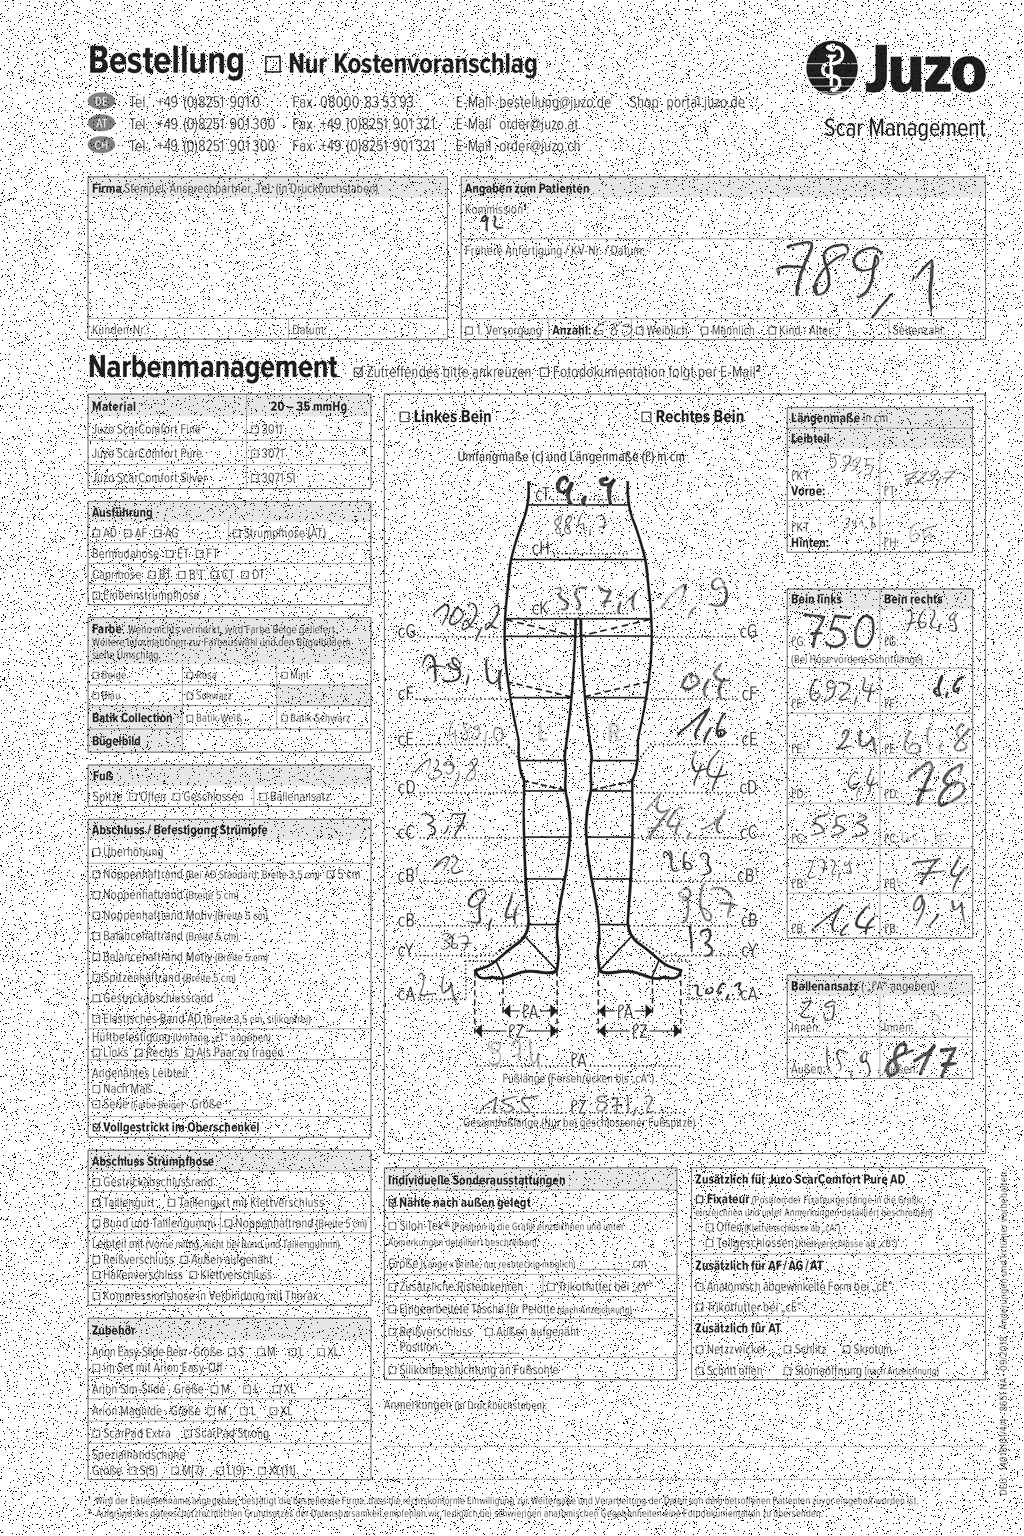

In [10]:
import PIL
PIL.Image.fromarray(np.array(x_val_tensor[0][0])).convert("L")

# Configure DivNoising model

Here we specify some parameters of our DivNoising network needed for training. The default parameters work well for most datasets.<br> 

$(i)$ The parameter <code>n_depth</code> specifies the depth of the network. <br> 
$(ii)$ <code>batch_size</code> specifies the batch size used for training. <br>
$(iii)$ <code>max_epochs</code> specifies the maximum number of training epochs. In practice, the training may termionate earlier if the validation loss does not improve for $30$ epochs. This is called [early stopping](https://keras.io/api/callbacks/early_stopping/). Currently, we have set ```max_epochs``` heuristically to compute it depending on the number of training patches such that 22 million steps will be taken in total with the entire data seen in each epoch. <br>
$(iv)$<code>model_name</code> specifies the name of the model with which the weights will be saved for prediction later. <br>
$(v)$<code>basedir</code> is the directory where the model and some logs will be saved during training. If this directory does not exist already, it will be created automatically. <br>
$(vi)$ Set <code>real_noise</code> to ```True``` if your dataset is intrinsically noisy. If your dataset is however corrupted synthetically by Gaussian noise, set this parameter to ```False```. If you choose ```real_noise=True```, then you will need to specify a noise model which you should have obtained by running either the notebook ```0a-CreateNoiseModel.ipynb``` or ```0b-CreateNoiseModel.ipynb```. If you have not yet generated the noise model for this dataset yet run that notebook first. 
If you choose ```real_noise=False```, then you should specify the standard deviation of the Gaussian noise used for synethtically corrupting the data. <br>
$(vii)$<code>noise_model</code> is the noise model you want to use. For real microscopy datasets which are intrinsically noisy, first run the notebook  ```0-CreateNoiseModel.ipynb```, if you have not yet generated the noise model for this dataset yet. <br>
$(viii)$<code>gaussian_noise_std</code> is only applicable if the dataset was synthetically corrupted with Gaussian noise. In this case, this parameter should be set to the standard deviation of the Gaussian noise used for synthetically corrupting the data. <br>

In [17]:
n_depth=2
batch_size=32
#max_epochs=int(22000000/(x_train_tensor.shape[0]))
max_epochs=200
model_name = 'exp_divnoising_dot_noise' # a name used to identify the model
basedir = '/home/fahad/master_thesis/vanilla_vae/models/unsupervised/DivNoising/exp_divnoising_dot_noise/checkpoints/' # the base directory in which our model will live
real_noise=True

if real_noise:
    noise_model_params= np.load("/home/fahad/master_thesis/vanilla_vae/models/unsupervised/DivNoising/exp_divnoising_dot_noise/GMM/GMMNoiseModel_synthetic_3_2_calibration.npz")
    noise_model = GaussianMixtureNoiseModel(params = noise_model_params, device = device)
    gaussian_noise_std = None
else:
    gaussian_noise_std = 25 # set it to the correct value if using data synthetically corrupted by Gaussian noise.

#### Start Tensorboard
Running the cell below will start a tensorboard instance within this notebook where we can monitor training progress after it starts. If you additionally wish to see tensorboard in a separate browser tab, run the cell first and go to the link http://localhost:6006/  with your browser. The advantage of viewing Tensorboard in a separate tab is that more screen space is allocated to Tensorboard, hence leading to a nicer visualization.

In [18]:
# %%capture
%load_ext tensorboard
%tensorboard --logdir=/home/fahad/master_thesis/vanilla_vae/models/unsupervised/DivNoising/exp_divnoising_dot_noise/checkpoints/

# Train network
Running the cell below trains the network and saves the model weights into the directory specified by ```basedir``` earlier. The best and the last models are saved along with tensorboard logs.

The number of network parameters and GPU/CPU usage information can be printed by setting the ```log_info``` parameter to ```True```. By default, it is turned off.

__Note:__ We observed that for certain datasets, it may happen that the training is getting aborted multiple times with the message `posterior collapse: aborting`. 
This happens when the KL loss goes towards 0. This phenomenon is called ```posterior collapse``` and is undesirable.
We try to prevent it by automatically checking the KL loss and aborting the training and restarting another training run once the KL drops below a threshold (```1e-7```). <br>

But if this happens for $20$ times, we start a procedure called [kl annealing](https://arxiv.org/abs/1511.06349) which is a way to avoid ```posterior collapse```. In this case, we increase the weight on KL divergence loss term from 0 to 1 gradually in a number of epochs (the default number of epochs for kl annealing is set to $10$ epochs). With kl annealing, we attempt the training again.

In [ ]:
training.train_network(x_train_tensor, x_val_tensor, batch_size, mean, std, 
                       gaussian_noise_std, noise_model, n_depth=n_depth, max_epochs=max_epochs, 
                       model_name=model_name, basedir=basedir, log_info=False)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]